In [2]:
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense
from tensorflow.keras.layers import Activation, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
pandas:  2.0.0
numpy:  1.22.2
seaborn:  0.12.2
matplotlib:  3.7.1
sklearn:  1.2.2
Tensorflow:  2.7.0


In [3]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [4]:
tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']


In [5]:
i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)


tensorlog:  nyc_taxi
dataFilePath:  data/nyc_taxi.csv


In [6]:
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
print(df.head(5))


Shape: 10320
Head:
             timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820


             timestamp  value            Datetime
0  2014-07-01 00:00:00  10844 2014-07-01 00:00:00
1  2014-07-01 00:30:00   8127 2014-07-01 00:30:00
2  2014-07-01 01:00:00   6210 2014-07-01 01:00:00


Text(0.5, 1.0, 'Time Series of value by date time')

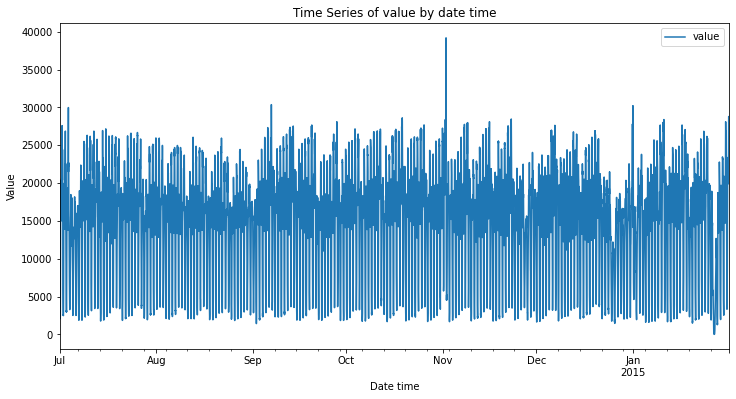

In [7]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
print(df.head(3))
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value'])
print('Shape:' , df.shape[0])
df.head(5)

Shape: 10320


,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


In [9]:
time_steps = 16

sequence = np.array(df['scaled_value'])
print(sequence)

# Create rolling window sequences as determined by time_steps
x_sequences = []
y_sequences = []

# Number of windows to iterate through
n_iter = len(sequence) - time_steps + 1
for f in range(n_iter):
    window = sequence[f:f+time_steps]
    x_sequences.append(window[:-1])
    y_sequences.append(window[-1:])
x_sequences = np.array(x_sequences)
y_sequences = np.array(y_sequences)
print(x_sequences.shape, y_sequences.shape)

[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]
(10305, 15) (10305, 1)


In [20]:
input_layer = Input(shape=(time_steps-1, 1))

#Series of temporal convolutional layers with dilations increasing by powers of 2.
conv_1 = Conv1D(filters=128, kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,
                kernel_regularizer=regularizers.l2(0.01),
                kernel_initializer='he_normal',
                activation='relu')(input_layer)

#Dropout layer after each 1D-convolutional layer
drop_1 = SpatialDropout1D(0.05)(conv_1)

conv_2 = Conv1D(filters=64, kernel_size=2, dilation_rate=2,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                kernel_initializer='he_normal',
                activation='relu')(drop_1)

drop_2 = SpatialDropout1D(0.05)(conv_2)

conv_3 = Conv1D(filters=32, kernel_size=2, dilation_rate=4,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                kernel_initializer='he_normal',
                activation='relu')(drop_2)

drop_3 = SpatialDropout1D(0.05)(conv_3)

conv_4 = Conv1D(filters=4, kernel_size=2, dilation_rate=8,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                kernel_initializer='he_normal',
                activation='relu')(drop_3)

flat = Flatten()(conv_4)
output = Dense(1, activation='relu')(flat)
tcn = Model(input_layer, output)


In [21]:
metric = 'mean_absolute_error'
tcn.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(tcn.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 1)]           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 15, 128)           384       
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 15, 128)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 15, 64)            16448     
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 15, 64)           0         
 lDropout1D)                                                     
                                                                 
 conv1d_6 (Conv1D)           (None, 15, 32)            4128

In [22]:
sequences_x = x_sequences.reshape(len(x_sequences), time_steps-1, 1)
print("sequences_x: ", sequences_x.shape)
sequences_y = y_sequences.reshape(len(y_sequences), 1)
print("sequences_y: ", sequences_y.shape)

# Training on first half of data only, predicting on whole thing
stop_point = int(0.5 * len(df))
training_x = sequences_x[:stop_point]
print("training_x: ", training_x.shape)
training_y = sequences_y[:stop_point]
print("training_y: ", training_y.shape)

batch_size=32
epochs=10

tcn.fit(x=training_x, y=training_y,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, validation_data=(training_x, training_y),
                       callbacks=[TensorBoard(log_dir='./logs/{0}'.format(tensorlog))])


sequences_x:  (10305, 15, 1)
sequences_y:  (10305, 1)
training_x:  (5160, 15, 1)
training_y:  (5160, 1)
Epoch 1/10
162/162 [==============================] - 10s 58ms/step - loss: 3.2908 - mean_absolute_error: 0.1490 - val_loss: 2.2728 - val_mean_absolute_error: 0.0654
Epoch 2/10
162/162 [==============================] - 8s 50ms/step - loss: 1.8847 - mean_absolute_error: 0.0665 - val_loss: 1.5691 - val_mean_absolute_error: 0.0572
Epoch 3/10
162/162 [==============================] - 8s 47ms/step - loss: 1.3648 - mean_absolute_error: 0.0581 - val_loss: 1.1732 - val_mean_absolute_error: 0.0497
Epoch 4/10
162/162 [==============================] - 5s 28ms/step - loss: 1.0351 - mean_absolute_error: 0.0532 - val_loss: 0.8991 - val_mean_absolute_error: 0.0481
Epoch 5/10
162/162 [==============================] - 1s 9ms/step - loss: 0.7961 - mean_absolute_error: 0.0499 - val_loss: 0.6945 - val_mean_absolute_error: 0.0459
Epoch 6/10
162/162 [==============================] - 1s 9ms/step - los

In [23]:
import math
from sklearn.metrics import mean_squared_error

testing_dataset = sequences_x
print("testing_dataset: ", testing_dataset.shape)

print("sequences_y: ", sequences_y.shape)

testing_pred = tcn.predict(x=testing_dataset)
print("testing_pred: ", testing_pred.shape)

errorsDF = sequences_y - testing_pred
print(errorsDF.shape)
rmse = math.sqrt(mean_squared_error(sequences_y, testing_pred))
print('Test RMSE: %.3f' % rmse)


testing_dataset:  (10305, 15, 1)
sequences_y:  (10305, 1)
testing_pred:  (10305, 1)
(10305, 1)
Test RMSE: 0.060


In [24]:
#based on cutoff after sorting errors
# Calculate threshold using training error
dist = np.linalg.norm(sequences_y[:len(training_y)] - testing_pred[:len(training_y)], axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print(cutoff)
threshold= scores[cutoff]

# Calculate total error over full sequence
dist = np.linalg.norm(sequences_y[:] - testing_pred, axis=-1)

print(threshold)


(5160,)
5154
0.16645004726088353


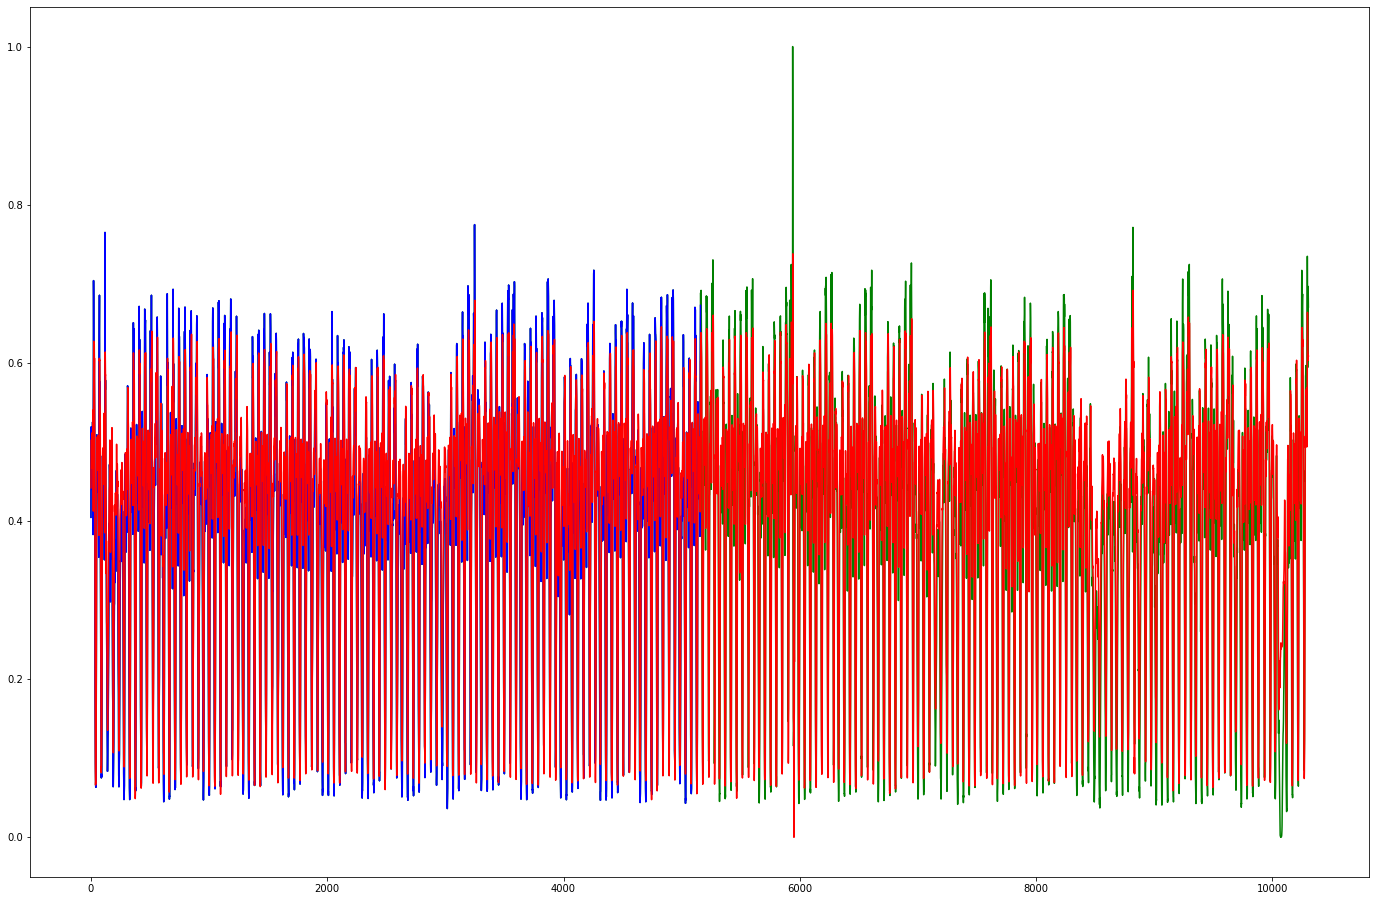

In [25]:
plt.figure(figsize=(24,16))
plt.plot(sequences_y, color='green')
plt.plot(training_y, color='blue')
plt.plot(testing_pred, color='red')


In [26]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)


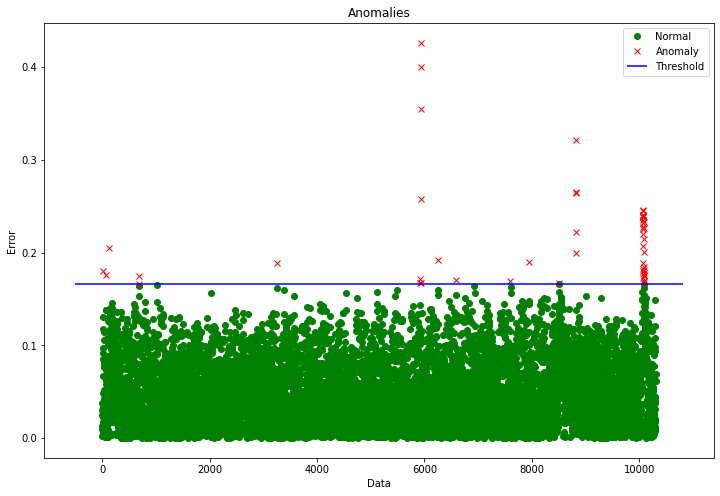

In [27]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)


In [28]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['value'],
                    'error': [0 for f in range((time_steps-1))] + error, 'anomaly': [0 for f in range((time_steps-1))]+ y_label})
adf.head(5)


,Datetime,observation,error,anomaly
0,2014-07-01 00:00:00,10844,0.0,0
1,2014-07-01 00:30:00,8127,0.0,0
2,2014-07-01 01:00:00,6210,0.0,0
3,2014-07-01 01:30:00,4656,0.0,0
4,2014-07-01 02:00:00,3820,0.0,0


Text(0.5, 1.0, 'Time Series of value by date time')

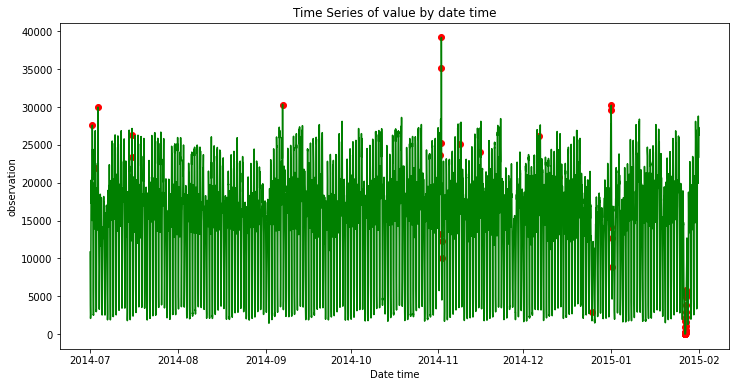

In [29]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')
